In [1]:
# Librerias generales
import pandas as pd
import numpy as np
import json

# Time
import datetime as dt
from datetime import datetime, timedelta

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from dython.model_utils import roc_graph
from dython.nominal import associations
%matplotlib inline

# OneHotEncoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

import os
import json

from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


# Algoritmos
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Pipeline
from sklearn.pipeline import make_pipeline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [2]:
data = pd.read_excel('six_loan_id.xlsx').drop(['Unnamed: 0'], axis=1)
data.head()

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73
2,241,25720,1076,10,2019-10-30,PAID,0,2019-10-30,5941645.15,5941645.15
3,241,25721,1076,11,2019-11-29,PAID,0,2019-11-29,5939653.40,5939653.40
4,241,25722,1076,12,2019-12-30,PAID,0,2019-12-30,5939653.40,5939653.40


In [3]:
# Cambiara formato datatime
data['paid_date']= pd.to_datetime(data['paid_date']) 
data['expected_date']= pd.to_datetime(data['expected_date']) 

In [4]:
# Aggregate data on a customer level
data = data.groupby(['client_id', 'loan_id']).agg({
    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'state': lambda x: x.iloc[-1], # Devuelve el último state
    'arrears_days':'mean',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
data.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
data.reset_index(inplace=True)
data.head()

,client_id,loan_id,recency,state,arrears_days,total_paid
0,241,1076,270.0,PAID,3.0,147915805.0
1,241,1244,270.0,PAID,4.0,91852726.0
2,362,1469,202.0,PAID,2.0,15211138.0
3,428,119,235.0,PAID,11.0,8713879.0
4,428,120,235.0,PAID,11.0,8102608.0


In [5]:
#Reemplazar missing values por el promedio
data.fillna(data.mean(), inplace=True)

In [6]:
data.isnull().sum()

client_id       0
loan_id         0
recency         0
state           0
arrears_days    0
total_paid      0
dtype: int64

In [7]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']

cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']
cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
data_transform = pd.DataFrame()
data_transform= data.merge(cat_data, left_on='client_id', right_on='ID Cliente').drop('ID Cliente', axis=1)
data_transform.head(8)

,client_id,loan_id,recency,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,1076,270.0,PAID,3.0,147915805.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,1244,270.0,PAID,4.0,91852726.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
2,362,1469,202.0,PAID,2.0,15211138.0,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0
3,428,119,235.0,PAID,11.0,8713879.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
4,428,120,235.0,PAID,11.0,8102608.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
5,429,998,591.0,PAID,11.0,34013973.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
6,429,1512,159.0,LATE,7.0,12358937.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
7,430,205,219.0,PAID,6.0,127943202.0,1299370581,KT - CO,Menos de 12 meses,Industria,Venture,Envigado,5,No,Si,810,20,Si,Si,Si,Si,24,Other,3,No,Si,22,No,0


In [8]:
data_transform.shape

(580, 29)

In [9]:
# Se elimina sin INFO de huellas de consulta y score bureau
#normalizada.replace('SIN INFO', np.nan)
data_transform = data_transform[data_transform['Score Bureau Empresa'] != "SIN INFO"]
data_transform = data_transform[data_transform['Huellas de Consulta'] != "SIN INFO"]
#normalizada = normalizada.dropna(how='all', axis=1)
data_transform.shape

(580, 29)

In [10]:
data_transform.columns

Index(['client_id', 'loan_id', 'recency', 'state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [11]:
#data_transform.reset_index(['client_id', 'loan_id'], inplace=True)
data_transform.drop(['client_id', 'loan_id'], axis=1, inplace=True)

In [12]:
data_transform.head(1)

,recency,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,270.0,PAID,3.0,147915805.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


In [13]:
[0.18487394957983194, 'PAID', 0.0, 0.0758139824074633, 0.07090128079784133, 'SP', '25 a 36 meses', 'Servicios', 'Seed', 'Bogotá D.C.', 0.75, 'No', 'Si', 0.9541751527494907, 0.2727272727272727, 'Si', 'No', 'No', 'Si', 0.34615384615384615, 'Internet', 0.014705882352941176, 'No', 'Si', 0.08416833667334668, 'No', 0.08]

[0.18487394957983194,
 'PAID',
 0.0,
 0.0758139824074633,
 0.07090128079784133,
 'SP',
 '25 a 36 meses',
 'Servicios',
 'Seed',
 'Bogotá D.C.',
 0.75,
 'No',
 'Si',
 0.9541751527494907,
 0.2727272727272727,
 'Si',
 'No',
 'No',
 'Si',
 0.34615384615384615,
 'Internet',
 0.014705882352941176,
 'No',
 'Si',
 0.08416833667334668,
 'No',
 0.08]

In [14]:
data_transform.columns

Index(['recency', 'state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

##### Correlation Between Categorical and Numerical

In [15]:
# Convert all the columns in float to integer for correlation plot as float is not handled
for y in data_transform.columns:
    if(data_transform[y].dtype == np.float64):
        data_transform[y] = data_transform[y].astype(int)

data_transform.dtypes

recency                          int32
state                           object
arrears_days                     int32
total_paid                       int32
Monto Acumulado                  int64
Uso de los recursos             object
Plazo                           object
Sector                          object
Ingresos                        object
Ubicación                       object
Estrato Mínimo                   int64
Procesos judiciales             object
Alertas                         object
Score Bureau Empresa            object
Huellas de Consulta             object
Website empresa                 object
Instagram empresa               object
LinkedIn empresa                object
LinkedIn empresarios            object
Edad empresarios                 int64
Activador                       object
Número de accionistas           object
Impacto                         object
Acceso previso a la banca       object
# Empleados                      int64
Mujeres empresarias      

In [16]:
# Columnas nominales
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                'Procesos judiciales', 'Alertas', 
                'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Activador',
                'Impacto', 'Acceso previso a la banca', 'Mujeres empresarias']

In [17]:
# Seleccionar todo dataframe
Data_Correlation=data_transform.iloc[:,:]

def data_associations():
    associations(Data_Correlation,nominal_columns=columnas_OHE)

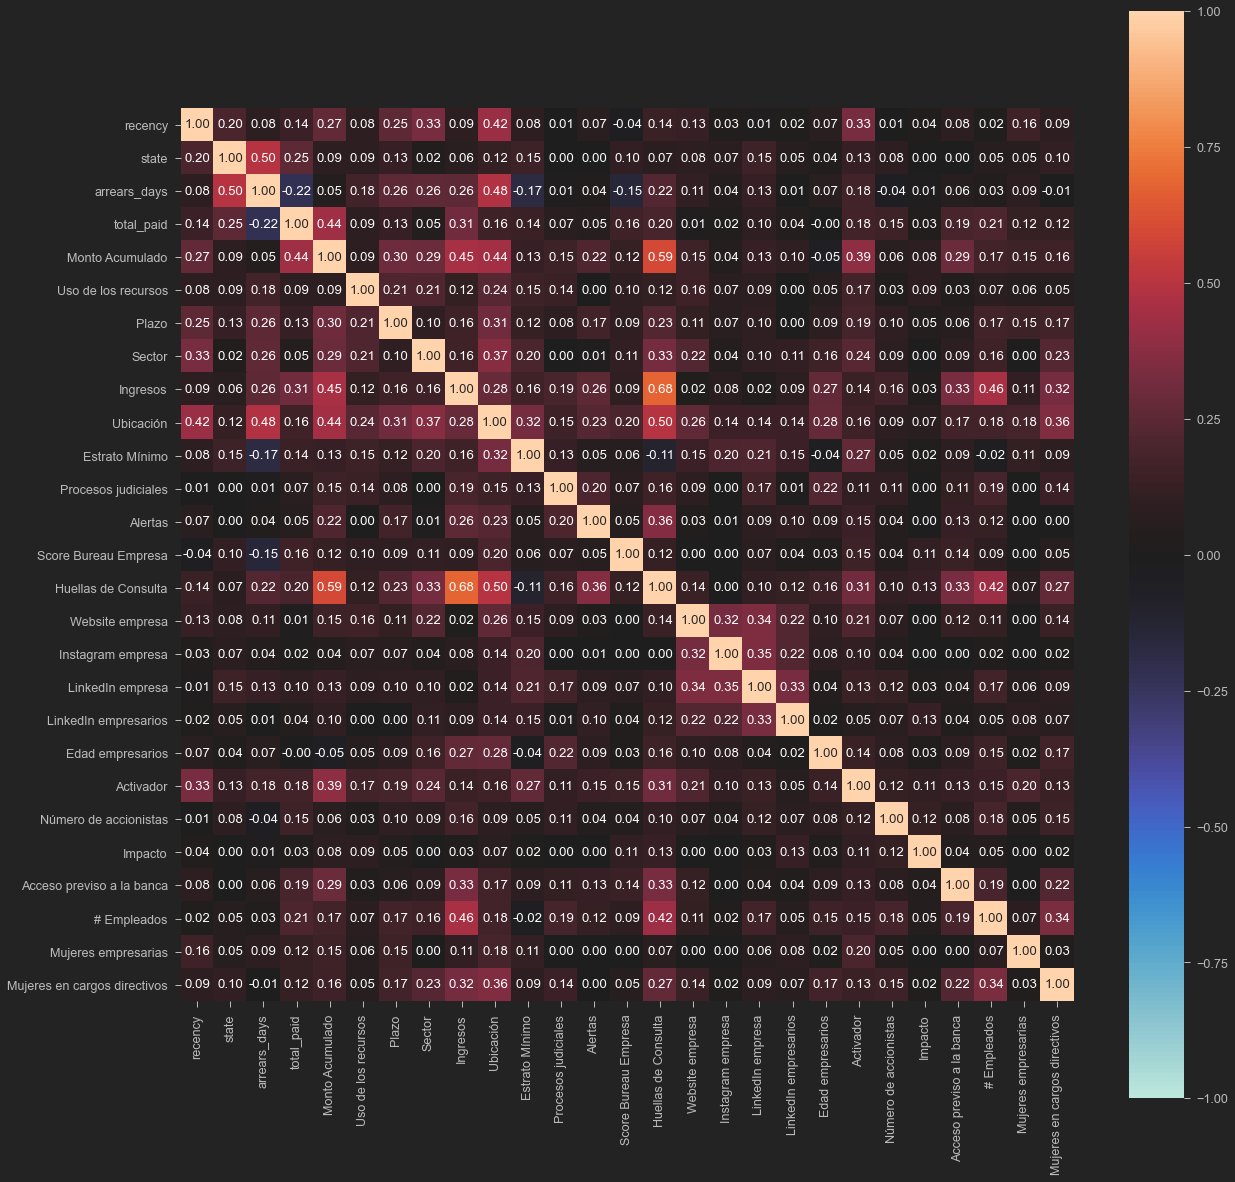

In [18]:
# Graficar correlación entre variables nominales y ordinales
plt.rcParams["figure.figsize"]=20,20
data_associations()

In [19]:
# Standardizing all the numerical variables
Num_features=data_transform.select_dtypes(include=[np.number]).columns
data_transform[Num_features]=preprocessing.MinMaxScaler().fit_transform(data_transform[Num_features])
data_transform.head()

,recency,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,0.256303,PAID,0.016667,0.418799,0.173314,CR,25 a 36 meses,Servicios,Seed,Medellín,0.75,No,No,0.941955,0.181818,Si,Si,Si,Si,0.442308,Internet,0.014706,No,Si,0.030060,No,0.08
1,0.256303,PAID,0.022222,0.260066,0.173314,CR,25 a 36 meses,Servicios,Seed,Medellín,0.75,No,No,0.941955,0.181818,Si,Si,Si,Si,0.442308,Internet,0.014706,No,Si,0.030060,No,0.08
2,0.184874,PAID,0.011111,0.043068,0.015756,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,0.25,No,No,0.940937,0.045455,Si,No,Si,No,0.192308,SocialNetworks,0.029412,No,Si,0.004008,No,0.00
3,0.219538,PAID,0.061111,0.024672,0.007878,SP,13 a 24 meses,Industria,Seed,Medellín,0.50,No,No,0.876782,0.022727,Si,No,Si,Si,0.423077,CreditProfessionalContact,0.014706,No,Si,0.008016,No,0.00
4,0.219538,PAID,0.061111,0.022941,0.007878,SP,13 a 24 meses,Industria,Seed,Medellín,0.50,No,No,0.876782,0.022727,Si,No,Si,Si,0.423077,CreditProfessionalContact,0.014706,No,Si,0.008016,No,0.00


##### Estadística de Hopkins
Prueba la aleatoriedad espacial de los datos e indica la tendencia de agrupación o lo bien que los datos pueden ser agrupados
* 0,5 o menos -->  los datos están distribuidos uniformemente
* 0.77 - 0.99 --> alta tendencia a los cluster 

In [20]:
# Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan


def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(
            X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [21]:
#Use a random sample of Data for faster computation
data_transform = data_transform.sample(200,random_state=41)
data_transform.head()

,recency,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
479,0.190126,PAID,0.011111,0.156939,0.173314,KT - CO,Menos de 12 meses,Servicios,Scale Up,Bogotá D.C.,0.50,Si,Si,0.818737,0.363636,Si,Si,No,Si,0.673077,Email,0.000000,Si,Si,0.098196,Si,0.16
293,0.265756,PARTIALLY_PAID,0.000000,0.036831,0.196948,KT - EX,Menos de 12 meses,Servicios,Seed,Medellín,0.75,No,No,0.953157,0.045455,Si,Si,Si,Si,0.326923,FriendOrColleague,0.014706,No,No,0.008016,Si,0.04
89,0.197479,LATE,0.033333,0.045501,0.063023,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,1.00,No,No,0.927699,0.090909,Si,Si,Si,Si,0.173077,Internet,0.014706,No,Si,0.040080,No,0.24
310,0.199580,LATE,0.022222,0.021415,0.063023,KT - CO,13 a 24 meses,Comercio,Venture,Medellín,1.00,Si,No,0.770876,0.204545,Si,No,Si,Si,0.519231,Email,0.000000,No,Si,0.016032,No,0.04
362,0.195378,PAID,0.016667,0.025950,0.181192,KT - EX,13 a 24 meses,Comercio,Seed,Bogotá D.C.,0.75,No,No,0.917515,0.045455,Si,Si,Si,Si,0.269231,FriendOrColleague,0.014706,No,Si,0.010020,No,0.00


In [22]:
#Resetting the indexs
data_transform=data_transform.reset_index(drop=True)

In [23]:
# Comprobar estadisticamente si la data si se puede clusterizar
Num_features =data_transform.select_dtypes(include=[np.number]).columns
hopkins(data_transform[Num_features])

0.8519827760258218

In [ ]:
#Rename the levels within in the CancellationCode column
data_transform['CancellationCode']=Data['CancellationCode'].replace(['N','A','B','C'],[0,1,2,3])
Data['CancellationCode']=Data['CancellationCode'].astype(object)
Data['Cancelled']=Data['Cancelled'].replace(["Cancelled","Not Cancelled"],[1,0])
Data['Cancelled']=Data['Cancelled'].astype(object)
Data.columns

In [ ]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

#normalizada = column_trans.fit_transform(data_transform)

In [ ]:
#Preprocessing numerical
numerical = data_transform.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = data_transform.select_dtypes(include='object')
#print(categorical)
#label_encoder = preprocessing.LabelEncoder()
le = preprocessing.LabelEncoder()
categorical= categorical[columnas_OHE].apply(le.fit_transform)
#categorical = label_encoder.fit(categorical)

#categorical = column_trans.fit_transform(categorical)

#categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(data_transform.select_dtypes(include='object').columns) / data_transform.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [ ]:
categorical_weight

In [ ]:
categorical_weight

In [ ]:
categorical_weight

### get_dummies

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

### OneHotEncoding

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

#### LabelEnconder

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

### Elbow method

In [ ]:
data = pd.get_dummies(data_transform)

In [ ]:
scores = []
# Set index
#normalizada.set_index(['client_id', 'loan_id'], inplace=True)
# Los valores nulos se reemplazan por el promedio de los valores
#normalizada.fillna(normalizada.mean(), inplace=True)

for k in range(1,11):
    km = KMeans(n_clusters=k,random_state=1)
    km = km.fit(data)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
data = pd.get_dummies(data_transform)
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [ ]:
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

### K-prototypes

In [ ]:
kprot_data = data_transform.copy()
for c in data_transform.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

In [ ]:
kprot_data_array = kprot_data.values

In [ ]:
categorical_columns = [1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16,
                      17, 18, 20, 21, 22, 23, 25] #make sure to specify correct indices

In [ ]:
kproto = KPrototypes(n_clusters= 3, init='Huang', n_jobs = 2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters = kproto.fit_predict(kprot_data_array, categorical=categorical_columns)

In [ ]:
pd.Series(clusters).value_counts()

#### Elbow plot with cost

In [ ]:
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 30)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

### Visualización

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=3),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [ ]:
#Imprimir centroides
print(kproto.cluster_centroids_)

In [ ]:
#
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)
cluster_dict

In [ ]:
data_transform['cluster'] = cluster_dict

In [ ]:
data_transform.head(3)

In [ ]:
sns.countplot(x='cluster', data=data_transform)

#### Evaluación de clasificación

In [ ]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, proto_clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

In [ ]:
clf_kp.fit(lgbm_data, proto_clusters)

In [ ]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

In [ ]:
data_transform.columns

In [ ]:
kprot_data.info()

In [ ]:
 i = 0
for k in kprot_data.columns:
    print(f'{i}: {k}')
    i += 1

In [ ]:
# Aggregate data on a customer level
data = data.groupby(['client_id', 'loan_id']).agg({
    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'state': lambda x: x.iloc[-1], # Devuelve el último state
    'arrears_days':'mean',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
data.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
data.reset_index(inplace=True)
data.head()

In [ ]:
# Aggregate data on a customer level
#datamart = data.groupby(['client_id', 'loan_id']).agg({
#    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
 #   'state': lambda x: x.iloc[-1], # Devuelve el último state
  #  'arrears_days':'mean',
   # 'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
#datamart.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
#datamart.reset_index(inplace=True)

#### NOTA: La frecuencia no será tenida en cuenta para este proyecto porque todos los datos se filtró por los últimos 6 meses. Por lo tanto, la frecuencia es la misma para todos los clientes.

In [ ]:
datamart = data.drop('state', axis=1)

In [ ]:
datamart.head(8)

In [ ]:
datamart['recency'].isnull().sum()

In [ ]:
datamart['recency']

In [ ]:
sns.catplot(x='total_paid', data=datamart, kind='box')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.total_paid,kde=True,bins=50)
plt.show()

In [ ]:
datamart.arrears_days.describe()

In [ ]:
sns.catplot(x='arrears_days', data=datamart, kind='box')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.arrears_days,kde=True,bins=50)
plt.show()

### Construyendo segmento RFM

+ Para la antiguedad(recency) se le asigna el mayor percentil al cliente que ha usado recientemente los servicios. Menor valor al que lleva tiempo sin usarlos.
+ Para el caso de la frecuencia(medida por los dias de retraso) y el valor monetario. Entre mayor sea el valor estas variables asi mismo se le asignara los percentiles

In [ ]:
datamart.describe()

In [ ]:
# Create numbered labels
r_labels = range(4,0,-1)

#Crear nuevo dataframe con los percentiles
recency_quartiles = pd.qcut(datamart['recency'], q=4, labels=r_labels)
datamart = datamart.assign(R = recency_quartiles.values)
datamart['R'].fillna(4, inplace=True)
datamart

##### Total pagado

In [ ]:
#f_quartiles = pd.qcut(datamart.arrears_days, q=4, labels=range(1,5))
t_quartiles = pd.qcut(datamart.total_paid, q=4, labels=range(1,5), precision=0)

# Agregar una nueva columna y asignar los valores
datamart = datamart.assign(T = t_quartiles.values)
datamart

##### Construcción de segmento RFM y RFM score
+ Concatenar los valores de los cuartiles
+ Sumar los valores de los cuartiles

In [ ]:
def join_rm(x): return str(x['R']) + str(x['T'])

datamart['RFM_Segment'] = datamart.apply(join_rm, axis=1)
datamart['RFM_Score'] = datamart[['R','T']].sum(axis=1)

In [ ]:
datamart

In [ ]:
datamart['RFM_Score'].value_counts()

### Clusterización preeliminar aplicando percentiles de metricas RFM

In [ ]:
def segment_me(df):
    if df['RFM_Score'] >= 7:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6):
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
    'recency': 'mean',
    'total_paid': ['mean', 'count']}).round(1)

#### Centrando varibles con diferentes 'means'

In [ ]:
# Copiar dataframe
datamart_rt = datamart

In [ ]:
# Dejar solo las columnas que se necesitan
datamart_rt.drop(['R', 'T', 'RFM_Segment', 'General_Segment'], axis=1, inplace=True)

In [ ]:
datamart_rt.head()

In [ ]:
datamart_centered = datamart_rt - datamart_rt.mean()
datamart_centered.describe().round(2)

In [ ]:
datamart

In [ ]:
#Reemplazar missing values por el promedio
datamart.fillna(datamart.mean(), inplace=True)

In [ ]:
analysis = datamart.drop(['client_id', 'loan_id'], axis=1)
analysis.head()

In [ ]:
corr_p = analysis.corr(method='pearson')
corr_p

In [ ]:
mask=np.zeros_like(corr_p,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):
    a=sns.heatmap(corr_p,mask=mask,vmax=0.7,square=True)

In [ ]:
corr_s = analysis.corr(method='spearman')
corr_s

In [ ]:
mask=np.zeros_like(corr_s,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):
    a=sns.heatmap(corr_s,mask=mask,vmax=0.7,square=True)

In [ ]:
# Revisar los features mas importantes del conjunto de datos
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn import utils

X = analysis.drop('recency',axis=1)
Y = analysis['recency']

# Transformación variable Y
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(Y)
#print(training_scores_encoded)

#print(utils.multiclass.type_of_target(Y))
#print(utils.multiclass.type_of_target(Y.astype('int')))
#print(utils.multiclass.type_of_target(training_scores_encoded))

clf = ExtraTreesClassifier()
clf = clf.fit(X, training_scores_encoded)
clf.feature_importances_

In [ ]:
# Implementación de features
new_data = analysis.copy()
new_data.drop('recency', axis=1)

# TODO: Split the data into training and testing sets using the given feature as the target

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, analysis['recency'], test_size = 0.2, random_state=1)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn import tree
regressor = tree.DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
from sklearn.metrics import accuracy_score
y_pred = regressor.predict(X_test)
#score = accuracy_score(y_test, y_pred)
#print ("The accuracy score is {}.".format(score))

In [ ]:
score = regressor.score(X_test, y_test)
print ("The accuracy score is {}.".format(score))

In [ ]:
#datamart_rt.set_index('client_id', inplace=True)

In [ ]:
#datamart_rt

Como se puede observar las desviaciones estandar no se encuentran en un mismo rango. Por lo que se hace necesario re escalar los datos. Se utilizará StandardScaler

### Rescalamiento de los datos 

In [ ]:
def reescalamiento(df):
    """Esta función reescala los datos financieros"""
    # Set index
    df.set_index(['client_id', 'loan_id'], inplace=True)
    # Los valores nulos se reemplazan por el promedio de los valores
    df.fillna(df.mean(), inplace=True)

    # Reescalar los datos
    scaler = StandardScaler()
    #scaler.fit(df)
    datamart_scaler = scaler.fit_transform(df)
    
    datamart_normalized = normalize(datamart_scaler)

    # Create a pandas DataFrame
    data_normalized_pandas = pd.DataFrame(
        datamart_normalized, index=df.index, columns=df.columns)

    data_normalized_pandas.reset_index(['client_id', 'loan_id'], inplace=True)

    return data_normalized_pandas

In [ ]:
normalizada_fin = reescalamiento(datamart_rt)

In [ ]:
normalizada_fin.head()

In [ ]:
normalizada_fin.isnull().sum()

In [ ]:
plt.figure(figsize=(20, 20)) # medidas del grafico 


plt.subplot(5,1,1)
plt.tight_layout()
plt.title("Data normalizada")

sns.distplot(normalizada_fin.total_paid)



plt.subplot(5,1,2)
plt.tight_layout()
plt.title("Datos sin normalizar")
sns.distplot(datamart.total_paid)
plt.show()

In [ ]:

sns.catplot(x='total_paid', data=normalizada_fin, kind='box')
plt.show()

In [ ]:
sns.catplot(x='total_paid', data=datamart, kind='box')
plt.show()

In [ ]:
plt.figure(figsize=(20, 20)) # medidas del grafico 


plt.subplot(5,1,1)
plt.tight_layout()
plt.title("Data normalizada")

sns.distplot(normalizada_fin.arrears_days)



plt.subplot(5,1,2)
plt.tight_layout()
plt.title("Datos sin normalizar")
sns.distplot(datamart.arrears_days)
plt.show()

#### AQUI SE HACE EL MERGE CON LA OTRA DATA

* Merge a los dataframe --> 'data_normalized_pandas' y los datos que hay en matriz cliente

In [ ]:
normalizada_fin.columns

In [ ]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']

cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']
cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
normalizada = pd.DataFrame()
normalizada_fin= pd.merge(normalizada_fin,data[['loan_id','state']],on='loan_id', how='left')
normalizada_fin.head(8)

In [ ]:
data_transform = normalizada_fin.merge(cat_data, left_on='client_id', right_on='ID Cliente').drop('ID Cliente', axis=1)
data_transform.head(6)

In [ ]:
# Se elimina sin INFO de huellas de consulta y score bureau
#normalizada.replace('SIN INFO', np.nan)
data_transform = data_transform[data_transform['Score Bureau Empresa'] != "SIN INFO"]
data_transform = data_transform[data_transform['Huellas de Consulta'] != "SIN INFO"]
#normalizada = normalizada.dropna(how='all', axis=1)
data_transform.shape

In [ ]:
data_transform.columns

### OneHotEncoding
* Agregar columnas
Activador 'Score Bureau Empresa', 'Huellas de Consulta'

In [ ]:
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                'Procesos judiciales', 'Alertas', 
                'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Activador',
                'Impacto', 'Acceso previso a la banca', 'Mujeres empresarias']

In [ ]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

In [ ]:
normalizada = column_trans.fit_transform(data_transform)
#print(data_transform)
print(column_trans.fit_transform(data_transform).tolist())

In [ ]:
column_trans

In [ ]:
#clean.shape

In [ ]:
# Imprimir cada columna del dataset clasificada por onehotencoder y los que no pasaron por el proceso de transformación
column_trans.get_feature_names()

#### Significado de OneHotEncoding
* state 

1 0 0--> Late

0 1 0--> PAID. 

0 0 1--> PARTIALLY_PAID

* Recursos 


1 0 0 0 --> CR

0 1 0 0 --> KT - CO

0 0 1 0--> KT - EX

0 0 0 1 --> SP

* Plazo

1 0 0 0 --> 13 a 24 meses

0 1 0 0 --> 25 a 36 meses

0 0 1 0--> Menos de 12 meses

0 0 0 1 --> Más de 37 meses

In [ ]:
normalizada

In [ ]:
normalizada.isnull().sum()

#### K means
K optimizado : eblow method

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(normalizada)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Fit KMeans and calculate SSE for each *k*
#sse = {}
#for k in range(1,11):
#    kmeans = KMeans(n_clusters=k, random_state=1)
#    kmeans.fit(data_transform)
#    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
#score_cluster = pd.DataFrame({'Cluster':range(1,11), 'Score':sse})
#plt.figure(figsize=(8,5))
# Plot SSE for each *k*
#plt.title('The Elbow Method')
#plt.xlabel('k'); plt.ylabel('SSE')
#sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
#plt.show()

In [ ]:
scores = []
# Set index
#normalizada.set_index(['client_id', 'loan_id'], inplace=True)
# Los valores nulos se reemplazan por el promedio de los valores
#normalizada.fillna(normalizada.mean(), inplace=True)

for k in range(1,11):
    km = KMeans(n_clusters=k,random_state=1)
    km = km.fit(normalizada)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
dfk

#### Valor de la silueta 
El valor de la silueta mide cuán similar es un punto a su propio cluster (cohesión) en comparación con otros cluster (separación).

In [ ]:
for i in range(2,17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(normalizada)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(normalizada,kmeans_labels, metric='euclidean').round(3)))

#### Métrica de Davies Bouldin
Medida de similitud promedio de cada cluster con su cluster más similar, donde la similitud es la relación entre las distancias dentro del cluster y las distancias entre los clusters. La puntuación mínima es cero, y los valores más bajos indican una mejor agrupación.

In [ ]:
for i in range(2, 17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(normalizada)
    print(f'Davies Bouldin Score {i}: {metrics.davies_bouldin_score(normalizada,kmeans_labels).round(3)}')

In [ ]:
kmeans_labels=KMeans(n_clusters=4,random_state=1).fit_predict(normalizada)

In [ ]:
pca = PCA(n_components=3).fit_transform(normalizada)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### MiniBatch K-Means

In [ ]:
for i in range(2,11):
    minikm_labels = MiniBatchKMeans(n_clusters=i,init='random',batch_size=100000).fit_predict(normalizada)
    print("Silhouette score for {} clusters MiniBatch k-means : {}".format(i,metrics.silhouette_score(normalizada, minikm_labels, metric='euclidean').round(3)))

In [ ]:
for i in range(2,11):
    minikm_labels = MiniBatchKMeans(n_clusters=i,init='random',batch_size=100000).fit_predict(normalizada)
    print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(normalizada,minikm_labels).round(3)))

In [ ]:
minikm_labels = MiniBatchKMeans(n_clusters=4,init='random',batch_size=100000).fit_predict(normalizada)

In [ ]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=minikm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Hierarchical Clustering

El eje x contiene las muestras y el eje y representa la distancia entre estas muestras.

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(normalizada, method='ward'))

Hay dos grupos de acuerdo con el dendograma. Y el umbral de corte es 3

In [ ]:
hcluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
hcp=hcluster.fit_predict(normalizada)
print('Silhouette Score for Hieararchial Clustering:'+str(metrics.silhouette_score(normalizada,hcp,metric='euclidean')))
print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(normalizada,hcp)))

In [ ]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=hcp,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Algoritmo DBSCAN

Agrupación basado en la densidad. La densidad se refiere a la proximidad de los puntos de datos en un cluster y es buena para los datos que contienen cluster de densidad similar.

In [ ]:
#  Construyendo el modelo con valores de épsilon y número natural de minPuntos.
results = pd.DataFrame(
    columns=['Eps', 'Min_Samples', 'Number of Cluster', 'Silhouette Score'])
for i in range(2, 12):
    for j in range(2, 12):
        dbscan_cluster = DBSCAN(eps=i*0.2, min_samples=j)
        clusters = dbscan_cluster.fit_predict(normalizada)
        if len(np.unique(clusters)) > 2:
            results = results.append({'Eps': i*0.2,
                                      'Min_Samples': j,
                                      'Number of Cluster': len(np.unique(clusters)),
                                      'Silhouette Score': metrics.silhouette_score(normalizada, clusters),
                                      'Davies Bouldin Score': metrics.davies_bouldin_score(normalizada, clusters)}, ignore_index=True)

In [ ]:
results.sort_values('Silhouette Score',ascending=False)[:5]

In [ ]:
dbscan_cluster = DBSCAN(eps=2.2, min_samples=3)
db_clusters=dbscan_cluster.fit_predict(normalizada)

In [ ]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=db_clusters,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Algoritmo GMM

Los Modelos de Mezcla Gaussiana (GMM) asumen que existen varias distribuciones Gaussianas, y cada una de ellas representa un cluster. Por lo tanto, un Modelo de Mezcla Gaussiana tiende a agrupar los puntos de datos que pertenecen a una única distribución.

<br>

**Determinar:**
+ n_conglomerados. 
+ El número óptimo de cluster (k) es el valor que minimiza el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC).



In [ ]:
# Determinar: n_conglomerados. 
# El número óptimo de cluster (k) es el valor que minimiza el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC).

models = [GaussianMixture(n,covariance_type='tied', random_state=1).fit(normalizada) for n in range(2,15)]
plt.plot(range(2,15), [m.bic(normalizada) for m in models], label='BIC')
plt.plot(range(2,15), [m.aic(normalizada) for m in models], label='AIC')
plt.legend()
plt.xlabel('n_components')
plt.show()

In [ ]:
parameters = ['full', 'tied', 'diag', 'spherical']
n_clusters = np.arange(1, 21)
results_ = pd.DataFrame(columns=[
                        'Covariance Type', 'Number of Cluster', 'Silhouette Score', 'Davies Bouldin Score'])
for i in parameters:
    for j in n_clusters:
        gmm_cluster = GaussianMixture(
            n_components=j, covariance_type=i, random_state=123)
        clusters = gmm_cluster.fit_predict(normalizada)
        if len(np.unique(clusters)) >= 2:
            results_ = results_.append({"Covariance Type": i, 'Number of Cluster': j, "Silhouette Score": metrics.silhouette_score(normalizada, clusters),
                                        'Davies Bouldin Score': metrics.davies_bouldin_score(normalizada, clusters)}, ignore_index=True)

In [ ]:
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:5])

In [ ]:
gmm_cluster=GaussianMixture(n_components=20,covariance_type="full",random_state=1)
gmm_cluster.fit(normalizada)
gmm_labels = gmm_cluster.predict(normalizada)

In [ ]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=gmm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### MeanShift

Asigna los puntos de datos a los clusters de forma iterativa desplazando los puntos hacia la mayor densidad de puntos de datos, es decir, el centroide del cluster.


In [ ]:
est_bandwidth = estimate_bandwidth(normalizada,quantile=0.1,n_samples=10000)
mean_shift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True).fit(normalizada)
labels_unique=np.unique(mean_shift.labels_)
n_clusters_=len(labels_unique)
print("Number of estimated clusters : %d" % n_clusters_)

In [ ]:
print('Silhouette Score for MeanShift:'+str(metrics.silhouette_score(normalizada,mean_shift.labels_,metric='euclidean').round(3)))
print('Davies Bouldin Score for MeanShift:'+str(metrics.davies_bouldin_score(normalizada,mean_shift.labels_).round(3)))

In [ ]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=mean_shift.labels_, cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

### Comparison of Results 

In [ ]:
algorithms=["K-Means","MiniBatch K-Means","Hierarchical Clustering","DBSCAN","Gaussian Mixture Model","MeanShift"]

# Silhouette Score
ss=[metrics.silhouette_score(normalizada,kmeans_labels),metrics.silhouette_score(normalizada,minikm_labels),metrics.silhouette_score(normalizada,hcp),
   metrics.silhouette_score(normalizada,db_clusters),metrics.silhouette_score(normalizada,gmm_labels),metrics.silhouette_score(normalizada,mean_shift.labels_)]

# Davies Bouldin Score
db=[metrics.davies_bouldin_score(normalizada,kmeans_labels),metrics.davies_bouldin_score(normalizada,minikm_labels),metrics.davies_bouldin_score(normalizada,hcp),
   metrics.davies_bouldin_score(normalizada,db_clusters),metrics.davies_bouldin_score(normalizada,gmm_labels),metrics.davies_bouldin_score(normalizada,mean_shift.labels_)]

In [ ]:
comprsn={"Algorithms":algorithms,"Davies Bouldin":db,"Silhouette Score":ss}
compdf=pd.DataFrame(comprsn)
display(compdf.sort_values(by=["Silhouette Score"], ascending=False))

**Hierarchical Clustering** tiene mayor puntuación tanto en el Silhouete score como en Davies Bouldin

In [ ]:
normalizada['Clusters']=list(hcp)
customers=pd.DataFrame(normalizada['Clusters'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers.T

In [ ]:
means=pd.DataFrame(normalizada.describe().loc['mean'])
means.T.iloc[:,[0,1,2,3]].round(1)

In [ ]:
normalizada.set_index('Clusters')
grouped=normalizada.groupby(by='Clusters').mean().round(1)
grouped.iloc[:,[0,1,2,3]]

In [ ]:
normalizada.columns

In [ ]:
features=['recency', 'arrears_days', 'total_paid', 'RFM_Score']
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.barplot(grouped.index,grouped[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

#### NOTA:
* Probar con otros normalizadores. PowerTransformer()